In [ ]:
# Copyright 2023 DeepMind Technologies Limited
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

In [ ]:
# Skip this cell if running from local environment
!pip install -q --no-warn-conflicts git+https://github.com/google-deepmind/nuclease_design.git
# After installing, restart the kernel
# Then run cells as normal

# Imports

In [ ]:
from Bio import AlignIO
import matplotlib.pyplot as plt
import numpy as np
import scipy
import seaborn as sns
import pandas as pd

from nuclease_design import amino_acids
from nuclease_design import constants
from nuclease_design import plotting
from nuclease_design import utils


In [ ]:
RANDOM_SEED = 0
DATA_DIR = constants.DATA_DIR

# Load data

In [ ]:
df = utils.load_all_data()

In [ ]:
df = utils.expand_sublibraries(df)

In [ ]:
ml_df = df[df['sublibrary_name'] == 'g4_mbo_dnn'].copy()
hr_df = df[df['sublibrary_name'] == 'g4_hit_recombination'].copy()

# Count number of mutations discovered

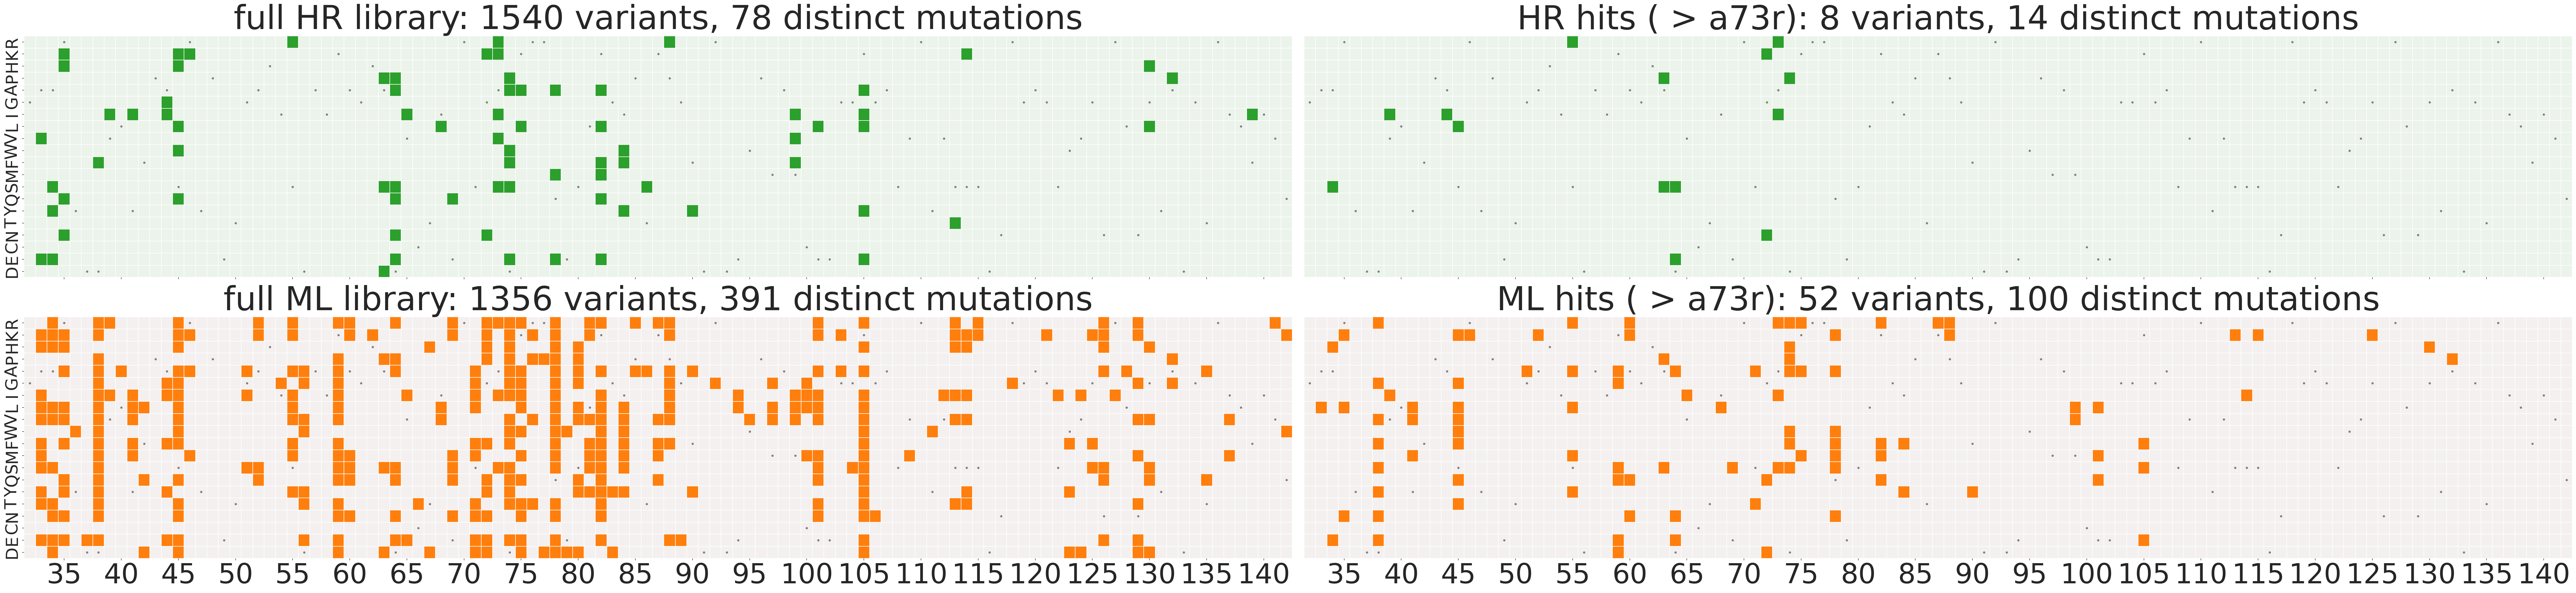

In [ ]:
plotting.make_mutation_heatmap_grid(hr_df, ml_df, 'HR', 'ML', parent_sequence=constants.FULL_REFERENCE_SEQ, fiducial='a73r', palette=[plotting.HR_COLOR, plotting.ML_COLOR])

# Alignment plot helpers

In [ ]:
def calculate_entropy(column):
    counts = {}
    for symbol in column:
        if symbol in counts:
            counts[symbol] += 1
        else:
            counts[symbol] = 1
    probabilities = pd.Series(counts).value_counts(normalize=True)
    return scipy.stats.entropy(probabilities, base=2)

def get_entropies(alignment):
    num_positions = len(alignment[0])
    entropies = []

    for position in range(num_positions):
        column = alignment[:, position].upper()  # ensure all tokens are upper case
        entropy = calculate_entropy(column)
        entropies.append(entropy)

    return entropies

In [ ]:
sns.set_style('ticks')

In [ ]:
VARIABLE_START = constants.G4_N_DESIGN_SEQUENCE_START # zero-indexed, inclusive
VARIABLE_END = constants.G4_C_DESIGN_SEQUENCE_END  # zero-indexed, exclusive

In [ ]:
with utils.open_file(constants.ALIGNMENT_PATH, 'r', DATA_DIR) as f:
  alignment = AlignIO.read(handle=f, format='fasta')

In [ ]:
%%time
entropies = np.array(get_entropies(alignment))

CPU times: user 3.27 s, sys: 48.2 ms, total: 3.32 s
Wall time: 3.29 s


In [ ]:
def plot_entropies(entropies, alignment, ax):
  GAP_TOKENS = ['-', '.']
  non_gap_positions = [i for i, aa in enumerate(alignment[0].seq) if aa not in GAP_TOKENS]
  non_gap_entropies = entropies[non_gap_positions]

  positions = np.arange(len(non_gap_positions))

  variable_positions = positions[VARIABLE_START:VARIABLE_END]
  one_indexed_variable_positions = variable_positions + 1
  variable_region_entropies = non_gap_entropies[VARIABLE_START:VARIABLE_END]
  ax.step(one_indexed_variable_positions, variable_region_entropies, color='black', where='pre', linewidth=2)


Text(0, 0.5, 'entropy')

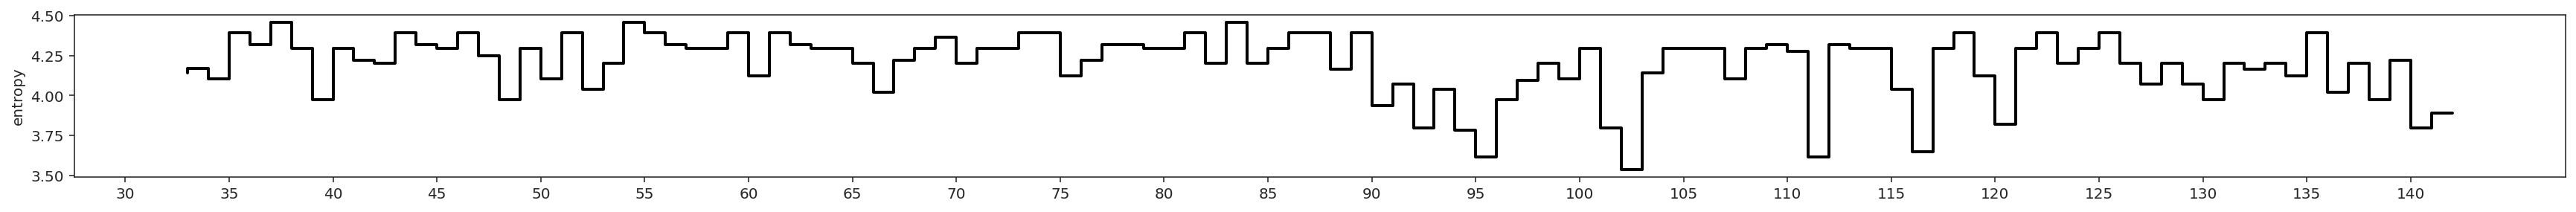

In [ ]:
fig, ax = plt.subplots(figsize=(30, 2), dpi=1000)

plot_entropies(entropies, alignment, ax)
# _ = plt.xticks(np.arange(0, len(non_gap_perplexities), 5))
# plt.xlim(left=VARIABLE_START, right=VARIABLE_END - 0.5)
xticks = np.arange(30, 145, 5)
plt.xticks(xticks)
plt.ylabel('entropy')

# Secondary structure

In [ ]:
def plot_secondary_structure(ax):
  alpha_value = 0
  beta_value = 1
  other_value = 2

  values = []
  # pad the beginning
  for _ in range(0, VARIABLE_START + 1):
    values.append(other_value)

  for i in range(VARIABLE_START + 1, VARIABLE_END + 1):
    ss = constants.get_secondary_structure(i)
    if not ss:
      values.append(other_value)
    else:
      if ss.startswith('alpha'):
        values.append(alpha_value)
      elif ss.startswith('beta'):
        values.append(beta_value)

  neutral_color = (239 / 255, 198 / 255, 158 / 255) # beige
  beta_color = (240 /255, 76 / 255, 75 / 255)  # red
  alpha_color = (61 / 255, 127 / 255, 194 / 255)  # blue
  cmap = sns.color_palette([alpha_color, beta_color, neutral_color], as_cmap=True)

  ss_values = np.expand_dims(values, axis=0)
  sns.heatmap(ss_values, cmap=cmap, ax=ax, cbar=False)
  ax.set_yticks([])

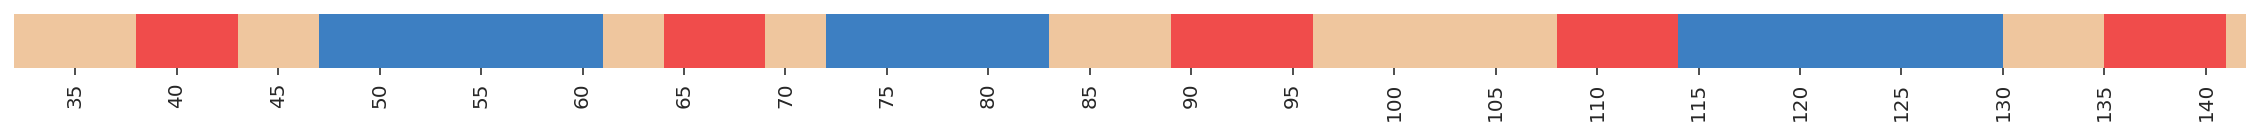

In [ ]:
fig, ax = plt.subplots(figsize=(20, 0.5), nrows=1, ncols=1)
plot_secondary_structure(ax)
_ = ax.set_xticks(ticks=xticks, labels=xticks)
_ = ax.set_xlim(left=VARIABLE_START, right=VARIABLE_END)

# Mega plot

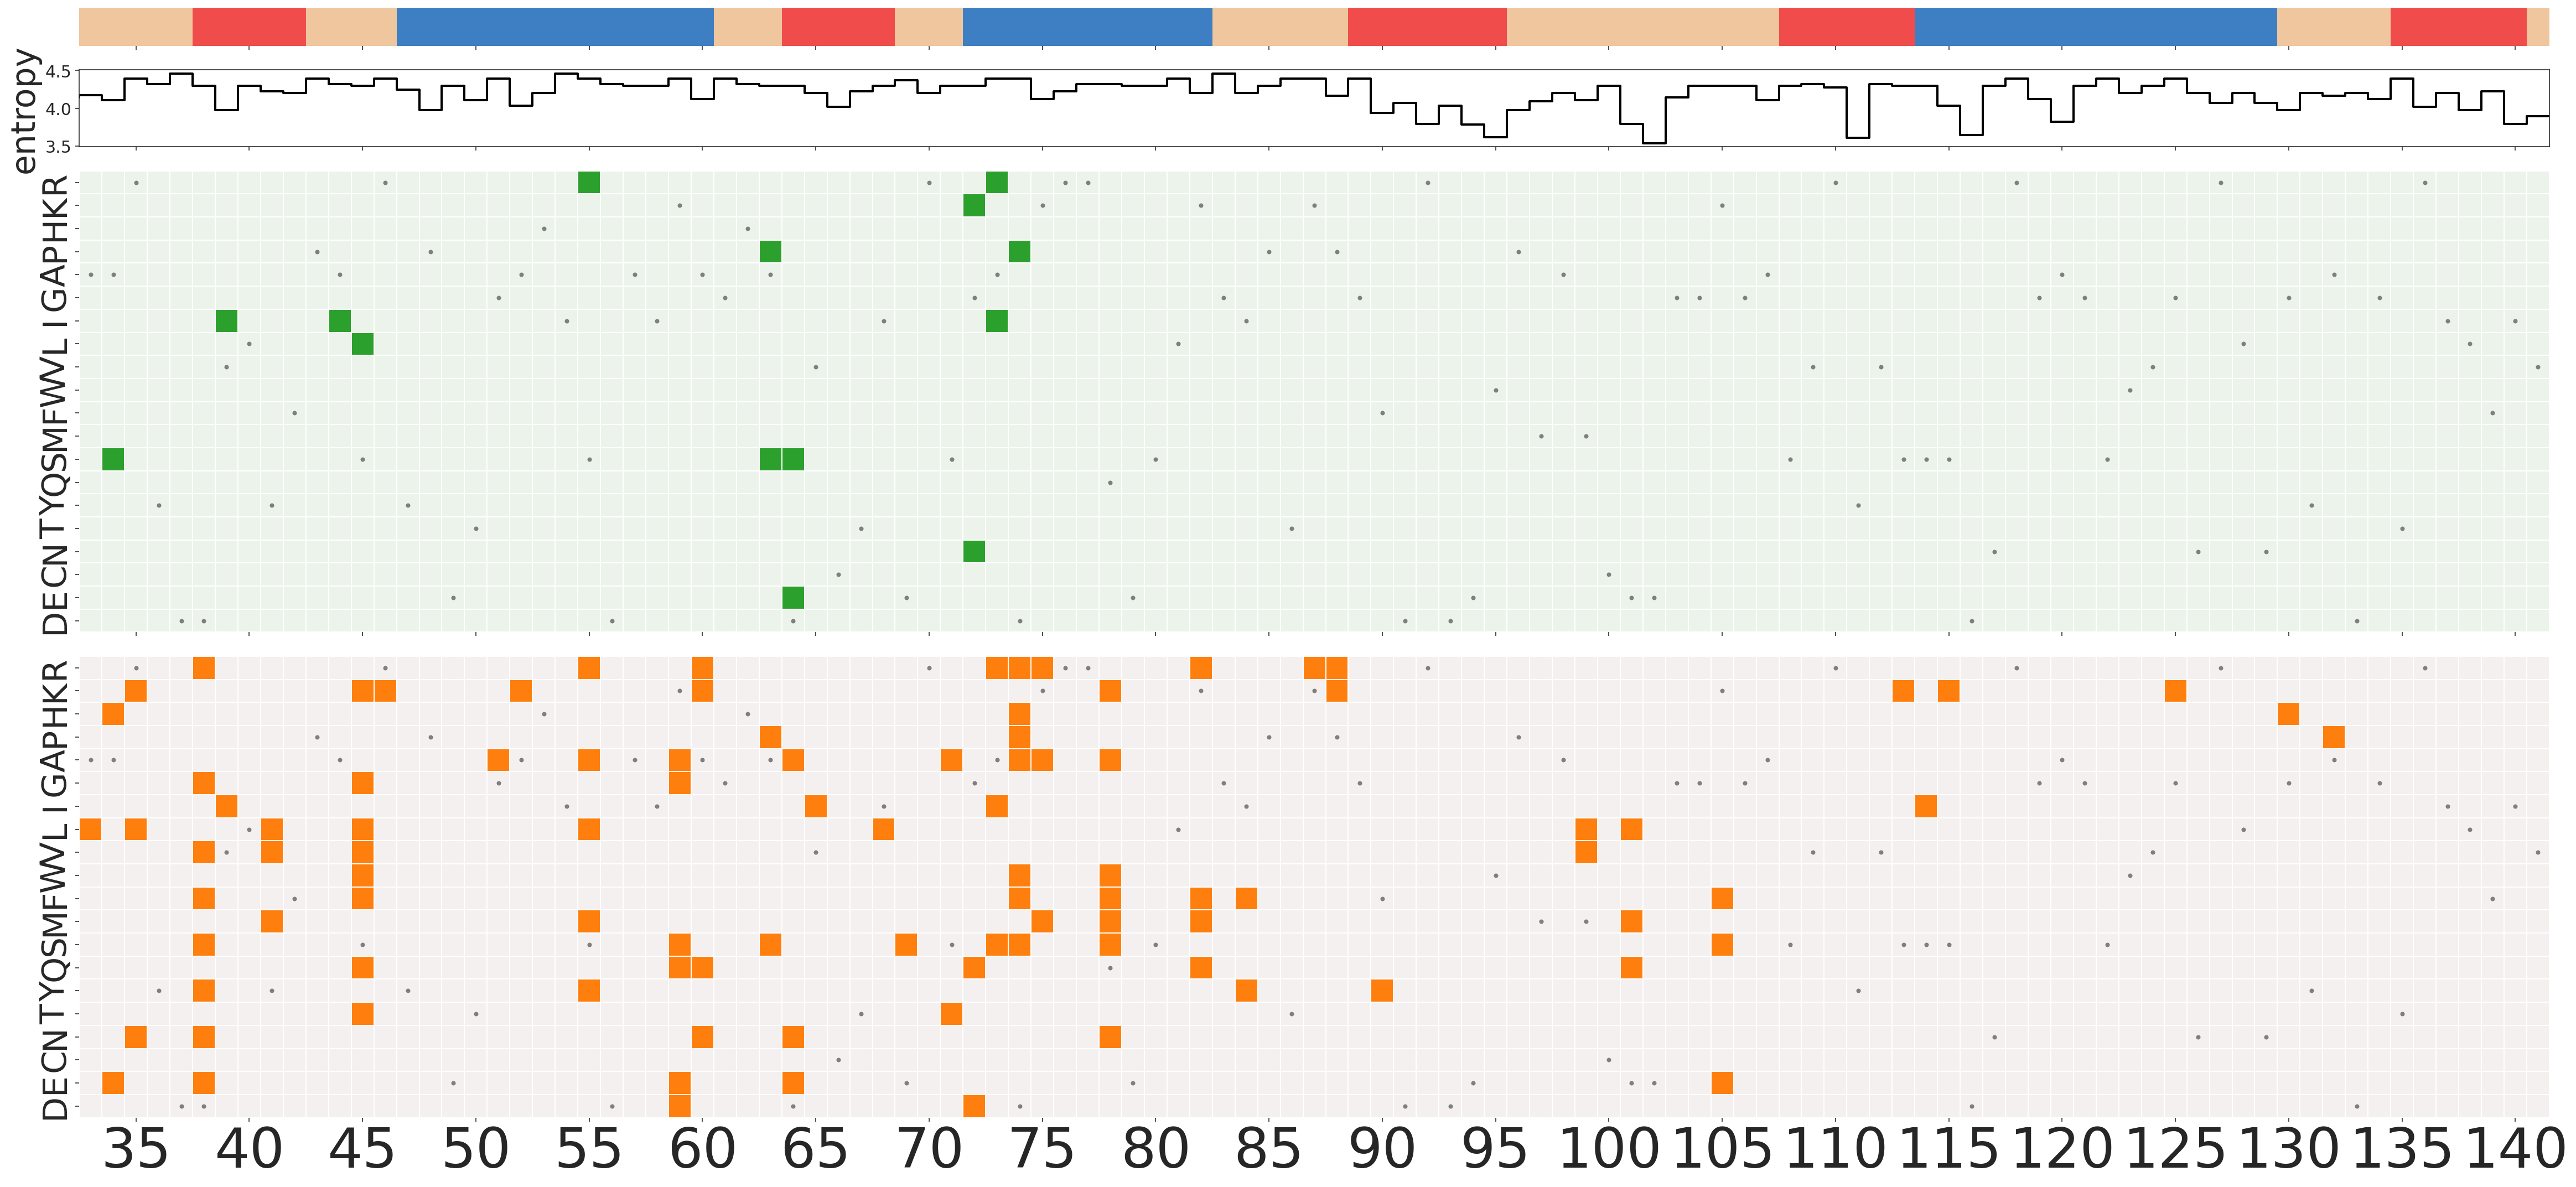

In [ ]:
fig, axs = plt.subplots(
    figsize=(65 / 2, 15),
    nrows=4,
    ncols=1,
    sharex=True,
    height_ratios=[0.25, 0.5, 3, 3],
    dpi=1000,
)

# secondary structure
i = 0
ax = axs[i]
plot_secondary_structure(ax)


# entropy
i = 1
ax = axs[i]
plot_entropies(entropies, alignment, ax)
ax.set_ylabel('entropy', fontsize=30)
ax.yaxis.set_tick_params(labelsize=15)


i = 2
colors = [plotting.HR_COLOR, plotting.ML_COLOR]
for j, plotdf in enumerate([hr_df, ml_df]):
  ax = axs[j + i]
  color = colors[j]
  df_to_plot = plotting._select_hits_at_threshold(plotdf, threshold='a73r')
  plotting.make_mutation_heatmap(
      mutations=df_to_plot['mutations'].explode().dropna(),
      ax=ax,
      use_y_ticks=True,
      use_x_ticks=True,
      inclusive_one_indexed_position_start=VARIABLE_START + 1,
      exclusive_one_indexed_position_end=VARIABLE_END + 1,
      color=color,
      parent_sequence=constants.FULL_REFERENCE_SEQ,
  )
  ax.yaxis.set_tick_params(labelsize=30)
  ax.xaxis.set_tick_params(labelsize=50)

_ = plt.xlim(left=VARIABLE_START + 1, right=VARIABLE_END)
plt.tight_layout()